# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Описание данных:

Признаки

   - DateCrawled — дата скачивания анкеты из базы
   - VehicleType — тип автомобильного кузова
   - RegistrationYear — год регистрации автомобиля
   - Gearbox — тип коробки передач
   - Power — мощность (л. с.)
   - Model — модель автомобиля
   - Kilometer — пробег (км)
   - RegistrationMonth — месяц регистрации автомобиля
   - FuelType — тип топлива
   - Brand — марка автомобиля
   - NotRepaired — была машина в ремонте или нет
   - DateCreated — дата создания анкеты
   - NumberOfPictures — количество фотографий автомобиля
   - PostalCode — почтовый индекс владельца анкеты (пользователя)
   - LastSeen — дата последней активности пользователя
   
Целевой признак

- Price — цена (евро)

## Подготовка данных

Импортируем необходимые библиотеки и инструменты

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from catboost import Pool, CatBoostRegressor
from lightgbm import LGBMRegressor
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

Загрузим данные и ознакомимся с ними

In [2]:
df = pd.read_csv('/datasets/autos.csv')

In [3]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


In [5]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


- Столбцы `VehicleType`, `Gearbox`, `Model`, `FuelType`, `NotRepaired` содержат пропуски в данных
- Столбцы `Price`, `RegistrationYear`, `Power`, `RegistrationMonth`, `NumberOfPictures` содержат странные данные

Ознакомимся с данными более подробно

Создадим функцию для построения "ящика с усами" 

In [6]:
def plot_boxplot(data, title, whis):

    plt.figure(figsize=(15,5))

    plt.title(title, fontsize=18)

    sns.boxplot(data=data, orient='h', whis=whis)

Создадим функцию для построения гистограммы

In [7]:
def plot_histplot(data, title, xlabel, bins, min, max):

    plt.figure(figsize=(15,5))

    plt.title(title, fontsize=18)
    
    plt.ylabel('Количество, шт.', fontsize=18)
    
    plt.xlabel(xlabel, fontsize=18)

    data.hist(bins=bins, range = (min, max), figsize = (15, 5))

Построим "ящик с усами" для цены автомобилей, при этом усы зададим равными 3IQR (соответствует очень грубым выбросам)

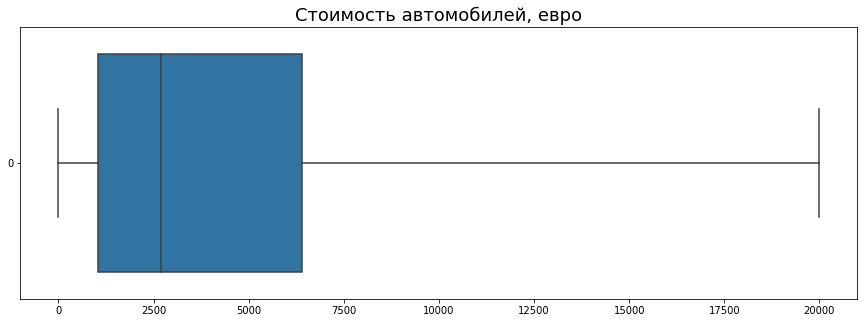

In [8]:
plot_boxplot(df['Price'], 'Стоимость автомобилей, евро', 3)

Видим, что грубых выбросов нет

Построим гистограмму для цены

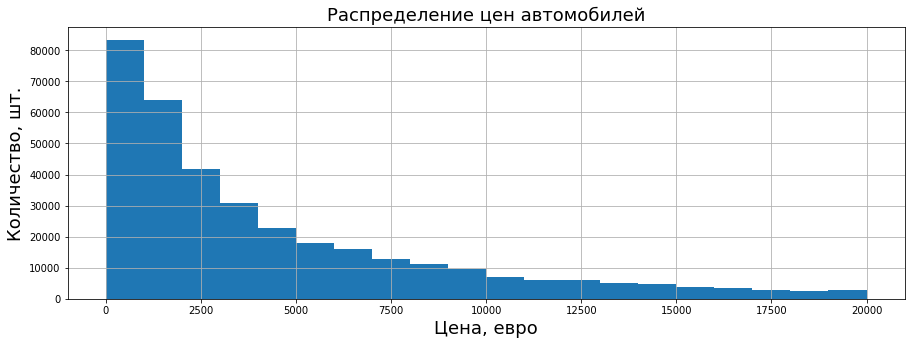

In [9]:
plot_histplot(df['Price'], 'Распределение цен автомобилей', 'Цена, евро', 20, 0, 20000)

Посмотрим внимательнее на низкие цены

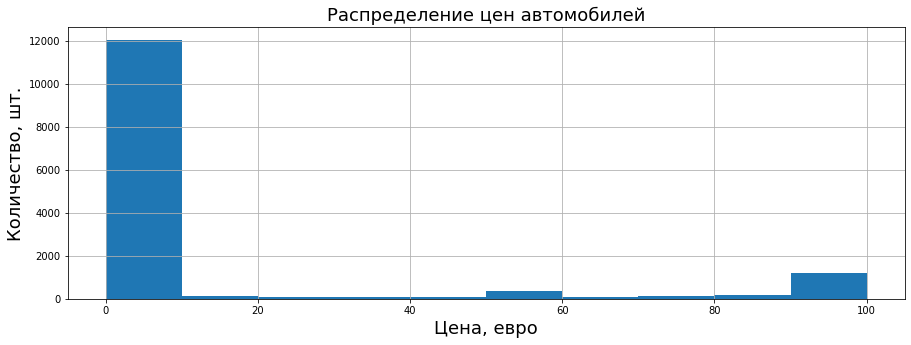

In [10]:
plot_histplot(df['Price'], 'Распределение цен автомобилей', 'Цена, евро', 10, 0, 100)

Анализ популярного сайта по продаже автомобилей показывает, что цены на небитые автомобили начинаются приблизительно от 10 тыс. руб. Удалим автомобили, которые дешевле 100 евро

In [11]:
df = df[df['Price'] > 100]

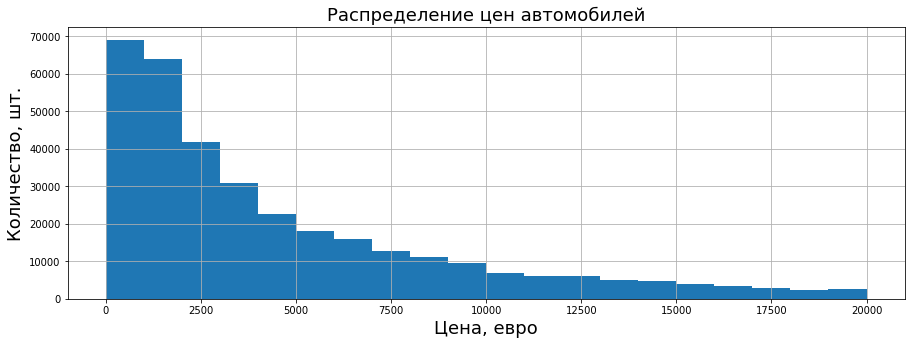

In [12]:
plot_histplot(df['Price'], 'Распределение цен автомобилей', 'Цена, евро', 20, 0, 20000)

Анализ популярного сайта по продаже автомобилей показывает, что маловероятно найти автомобиль ранее 1900 года регистрации. Удалим автомобили с более ранним годом регистрации

In [13]:
df = df[df['RegistrationYear'] > 1900]

Посмотрим на гистограмму по последним возможным годам регистрации

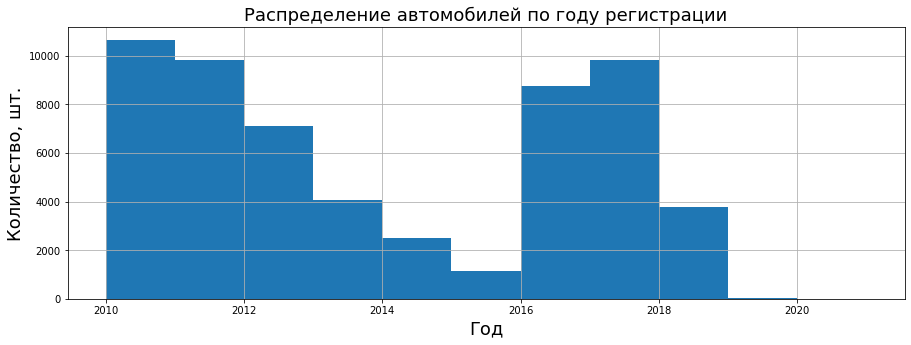

In [14]:
plot_histplot(df['RegistrationYear'], 'Распределение автомобилей по году регистрации', 'Год', 11, 2010, 2021)

Видим, что последний возможный год регистрации 2019. Удалим автомобили с большим годом регистрации

In [15]:
df = df[df['RegistrationYear'] < 2020]

Построим гистограмму по годам регистрации

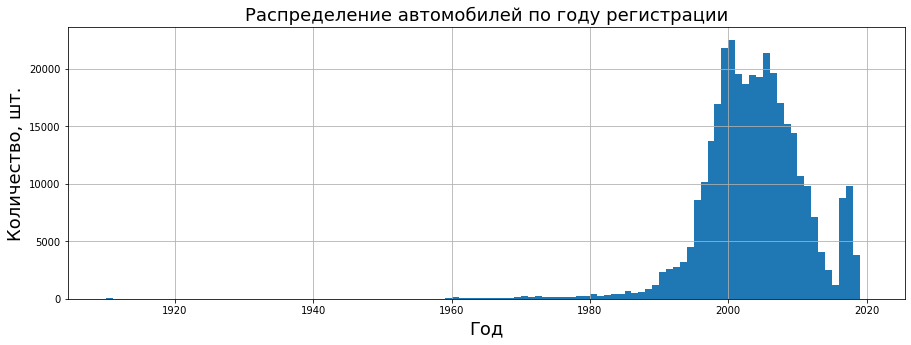

In [16]:
plot_histplot(df['RegistrationYear'], 'Распределение автомобилей по году регистрации', 'Год', 110, 1910, 2020)

Анализ популярного сайта по продаже автомобилей показывает, что маловероятно найти автомобиль с мощностью менее 5 л.с. Удалим автомобили с мощностью менее 5 л.с.

In [17]:
df = df[df['Power'] > 4]

Анализ популярного сайта по продаже автомобилей показывает, что маловероятно найти автомобиль с мощностью более 1000 л.с. Удалим автомобили с мощностью более 1000 л.с.

In [18]:
df = df[df['Power'] < 1000]

Построим гистограмму по мощности

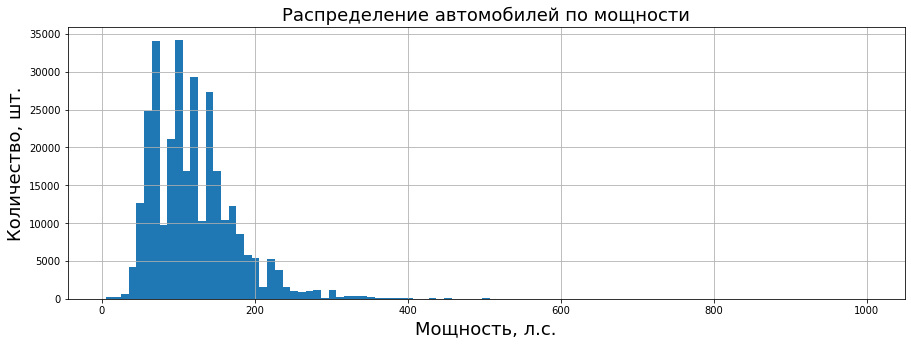

In [19]:
plot_histplot(df['Power'], 'Распределение автомобилей по мощности', 'Мощность, л.с.', 99, 5, 1000)

Построим гистограмму по пробегу

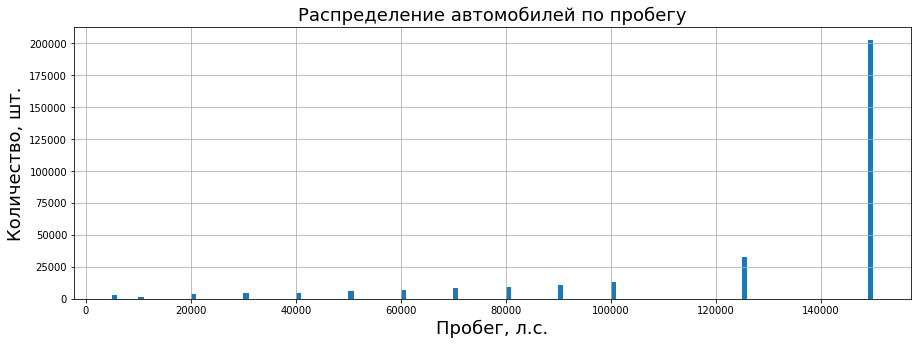

In [20]:
plot_histplot(df['Kilometer'], 'Распределение автомобилей по пробегу', 'Пробег, л.с.', 145, 5e3, 150e3)

В реальном бизнесе попросил бы комментарии коллег по такой гистограмме

Создадим функцию для построения столбчатой диаграммы

In [21]:
def plot_barh(data, title, xlabel, ylabel, figsize=(15,7)):

    plt.title(title, fontsize=18)
    
    plt.ylabel(ylabel, fontsize=18)
    
    plt.xlabel(xlabel, fontsize=18)

    data.value_counts().plot(kind='barh', figsize=figsize)

Построим диаграмму для типов кузовов

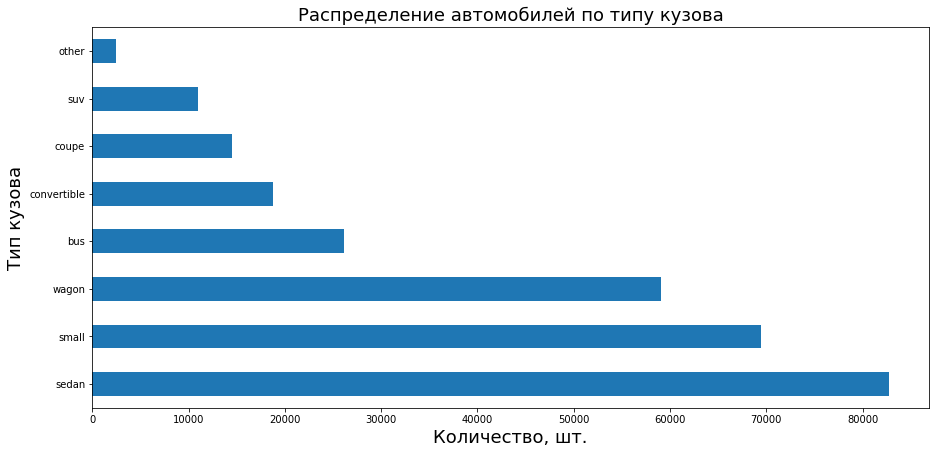

In [22]:
plot_barh(df['VehicleType'], 'Распределение автомобилей по типу кузова', 'Количество, шт.', 'Тип кузова')

Построим диаграмму для типов коробки передач

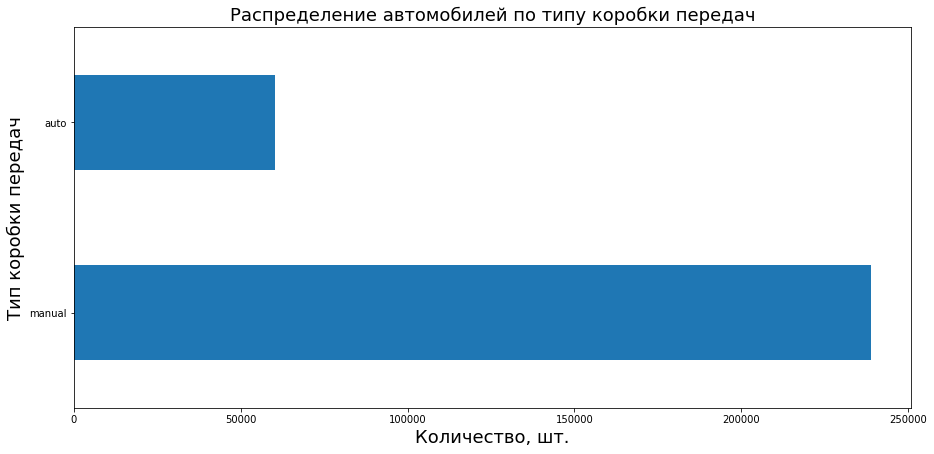

In [23]:
plot_barh(df['Gearbox'], 'Распределение автомобилей по типу коробки передач', 'Количество, шт.', 'Тип коробки передач')

Построим диаграмму для месяцев регистрации

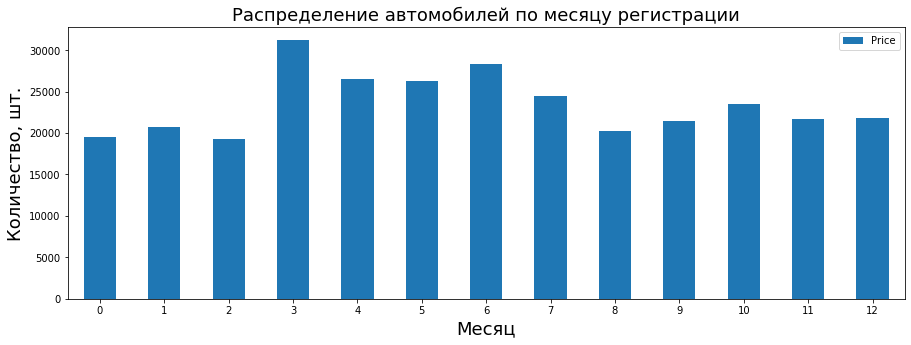

In [24]:
month_df = df.pivot_table(index='RegistrationMonth', values='Price', aggfunc='count')

month_df.plot(kind='bar', figsize = (15, 5), rot=0)

plt.title('Распределение автомобилей по месяцу регистрации', fontsize=18)

plt.ylabel('Количество, шт.', fontsize=18)

plt.xlabel('Месяц', fontsize=18)

plt.show()

Посмотрим на среднюю цену по месяцам регистрации

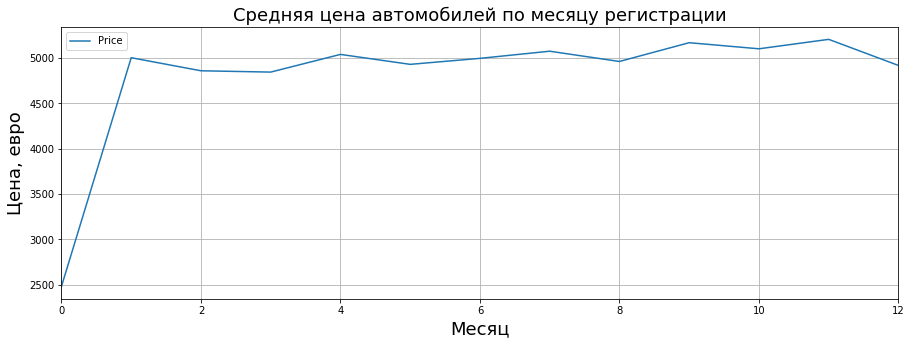

In [25]:
month_price = df.pivot_table(index='RegistrationMonth', values='Price', aggfunc='mean')

month_price.plot(kind='line', figsize = (15, 5), rot=0, grid=True)

plt.title('Средняя цена автомобилей по месяцу регистрации', fontsize=18)

plt.ylabel('Цена, евро', fontsize=18)

plt.xlabel('Месяц', fontsize=18)

plt.show()

Цена в непонятный месяц 0 заметно меньше, чем в остальные месяцы

Построим "ящики с усами" для цены каждого месяца регистрации

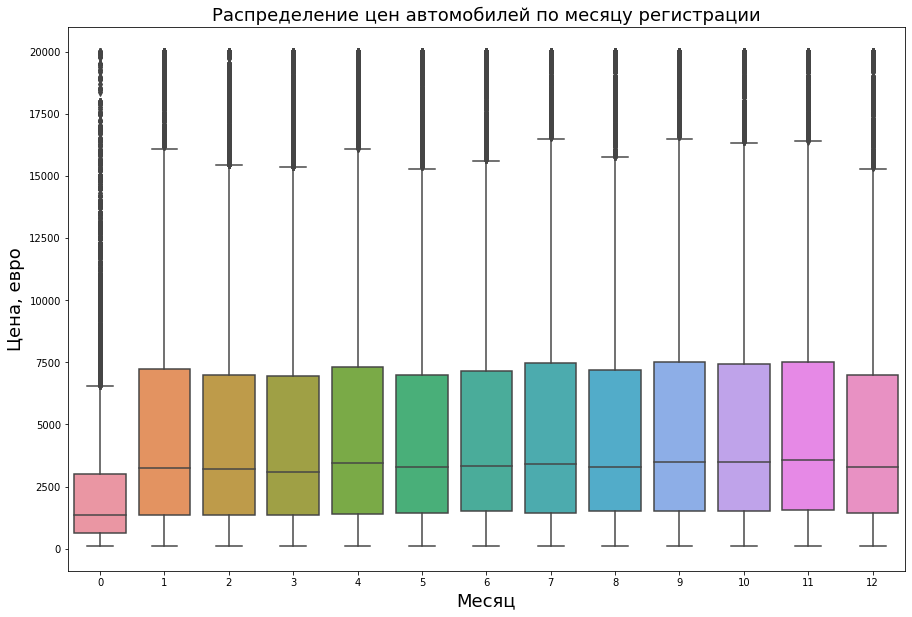

In [26]:
plt.figure(figsize=(15,10))

sns.boxplot(x='RegistrationMonth', y='Price', data=df)

plt.title('Распределение цен автомобилей по месяцу регистрации', fontsize=18)

plt.ylabel('Цена, евро', fontsize=18)

plt.xlabel('Месяц', fontsize=18)

plt.show()

Поведение цены в непонятный месяц 0 заметно отличается от остальных месяцев

Удалим автомобили с 0 месяцем и поговорим с коллегами об этом (также были дополнительно выборочно просмотрены строки с такими автомобилями, никаких других странностей в них не обнаружено)

In [27]:
df = df[df['RegistrationMonth'] !=0]

Создадим столбец `Age`, кторый будет содержать информацию о возрасте автомобиля в днях (будем считать, что у нас сейчас декабрь 2019)

In [28]:
df['Age'] = (2019 - df['RegistrationYear']) * 365 + (12 - df['RegistrationMonth']) * 30

Построим гистограмму для возрасту

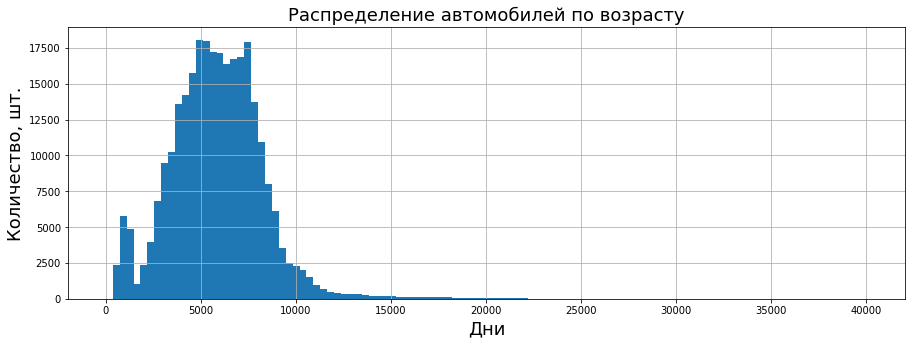

In [29]:
plot_histplot(df['Age'], 'Распределение автомобилей по возрасту', 'Дни', 110, 0, 40040)

Построим диаграмму для типов топлива

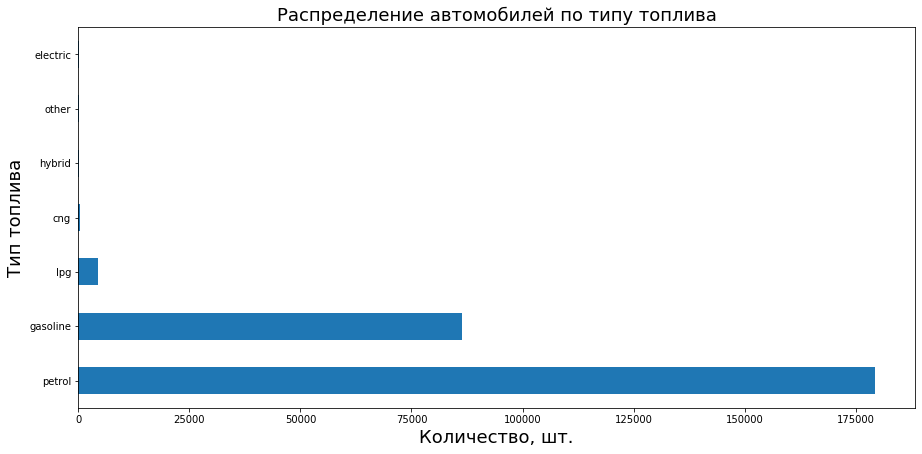

In [30]:
plot_barh(df['FuelType'], 'Распределение автомобилей по типу топлива', 'Количество, шт.', 'Тип топлива')

Построим диаграмму для марок

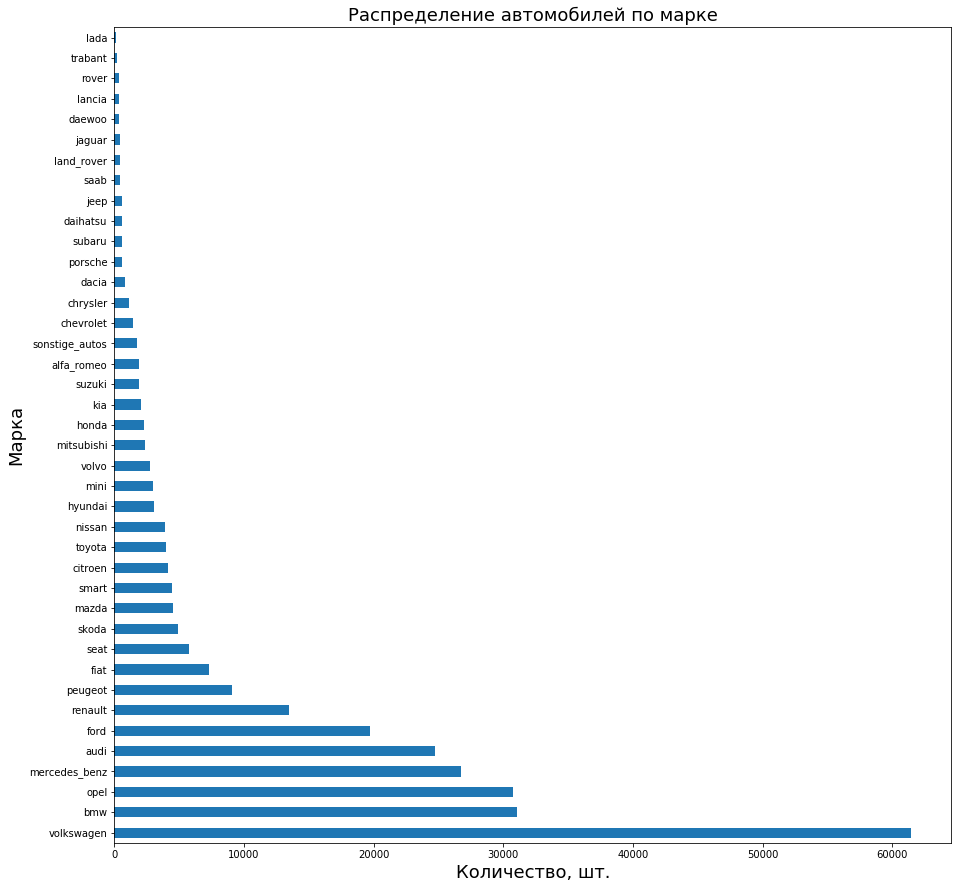

In [31]:
plot_barh(df['Brand'], 'Распределение автомобилей по марке', 'Количество, шт.', 'Марка', (15, 15))

Удалим ненужные столбцы `NumberOfPictures` (содержит только нулевые значения), `DateCrawled`(ненужные данные), `DateCreated`(ненужные данные), `PostalCode`(ненужные данные), `LastSeen`(ненужные данные), `RegistrationMonth`(после введения возраста ненужные данные)

In [32]:
names = ['NumberOfPictures', 'DateCrawled', 'DateCreated', 'PostalCode', 'LastSeen', 'RegistrationMonth'] 

In [33]:
for name in names:
    
    df = df.drop([name], axis=1)

Заполним пропуски в столбцах `VehicleType`, `Gearbox`, `Model`, `FuelType` значением `unknown`

In [34]:
names = ['VehicleType', 'Gearbox', 'Model', 'FuelType']

In [35]:
for name in names:
    
    df[name] = df[name].fillna('unknown')

Посмотрим на данные столбца `NotRepaired`

In [36]:
df['NotRepaired'].value_counts(normalize=1)

no     0.895168
yes    0.104832
Name: NotRepaired, dtype: float64

Построим график средней доли машин с ремонтом в зависимости от года регистрации

In [37]:
df_reparied = df[['NotRepaired', 'RegistrationYear']]

In [38]:
df_reparied = df_reparied.replace({'NotRepaired': {'yes': 1, 'no': 0}})

In [39]:
df_reparied_pivot = df_reparied.pivot_table(index='RegistrationYear', values='NotRepaired', aggfunc='mean')

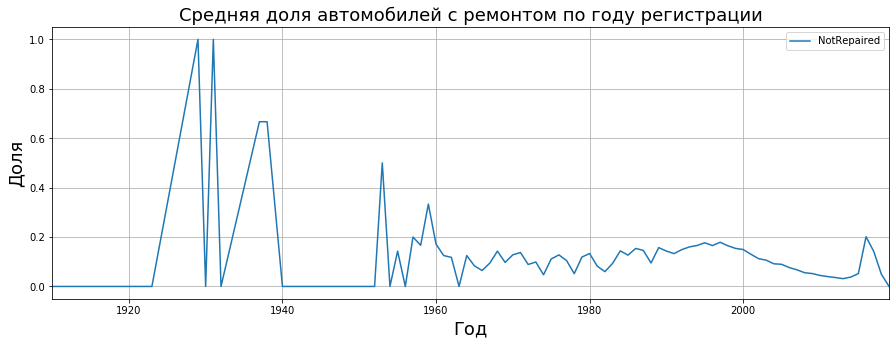

In [40]:
df_reparied_pivot.plot(kind='line', figsize = (15, 5), rot=0, grid=True)

plt.title('Средняя доля автомобилей с ремонтом по году регистрации', fontsize=18)

plt.ylabel('Доля', fontsize=18)

plt.xlabel('Год', fontsize=18)

plt.show()

График до 1960 года можно не рассматривать, т.к. там мало данных, далее доля держится около 0,15. Значит нам можно заполнить пропуски так, чтобы не сильно нарушить имеющееся соотношение 

Заполним пропуски и убедимся, что соотношение осталось примерно прежним

In [41]:
df['NotRepaired'] = df['NotRepaired'].fillna('no')

In [42]:
df['NotRepaired'].value_counts(normalize=1)

no     0.908643
yes    0.091357
Name: NotRepaired, dtype: float64

Удалим столбец `RegistrationYear`

In [43]:
df = df.drop(['RegistrationYear'], axis=1)

Построим матрицу корреляции

In [44]:
df.corr()

,Price,Power,Kilometer,Age
Price,1.000000,0.500576,-0.394307,-0.440414
Power,0.500576,1.000000,0.108212,-0.111824
Kilometer,-0.394307,0.108212,1.000000,0.277127
Age,-0.440414,-0.111824,0.277127,1.000000


Мультиколлинеарных признаков нет

Сбросим индексы в таблице для дальнейшей работы

In [45]:
df = df.reset_index(drop=True)

Применим порядковое кодирование для категориальных признаков и сохраним результат в новой таблице

In [46]:
categorical = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand']

encoder = OrdinalEncoder()

df_ordinal = pd.DataFrame(encoder.fit_transform(df[categorical]), columns=df[categorical].columns)

Добавим в новую таблицу количественные признаки

In [47]:
numeric = ['Age', 'Power', 'Kilometer', 'Price']

In [49]:
df_ordinal[numeric] = df[numeric]

In [50]:
for name in categorical:
    
    df_ordinal[categorical] = df_ordinal[categorical].astype('int64')

Сохраним целевые признаки и признаки

In [52]:
target = df_ordinal['Price']

features = df_ordinal.drop('Price', axis=1)

Разделим данные на обучающие и тестовые

In [54]:
features_train, features_test, target_train, target_test = train_test_split(
features, target, test_size=0.25, random_state=12345)

Убедимся, что распределения цен в обучающих и тестовых данных одинаково

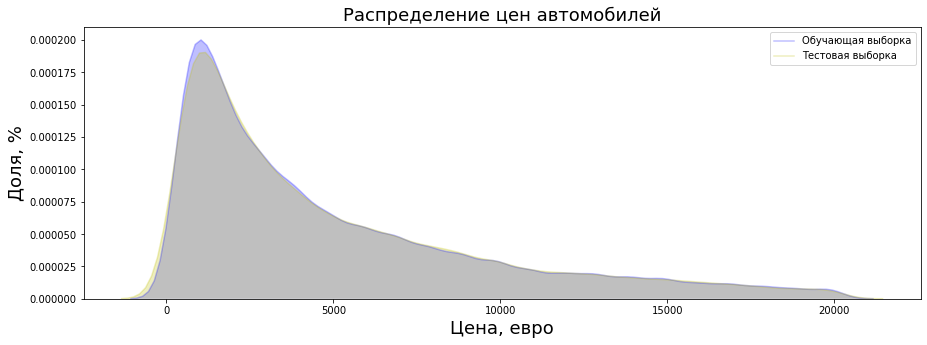

In [55]:
plt.figure(figsize=(15, 5))
    
sns.kdeplot(target_train, shade=True, color="b", label='Обучающая выборка', alpha=.25)
    
sns.kdeplot(target_test, shade=True, color="y", label='Тестовая выборка', alpha=.25)

plt.title('Распределение цен автомобилей', fontsize=18)
    
plt.xlabel('Цена, евро', fontsize=18)
    
plt.ylabel('Доля, %', fontsize=18)
    
plt.legend()
    
plt.show()

In [56]:
numeric = ['Age', 'Power', 'Kilometer']

Выполним масштабирование признаков выборок

In [57]:
scaler = StandardScaler()

scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])

features_test[numeric] = scaler.transform(features_test[numeric])

## Обучение моделей

Создадим функцию для подбора лучших гиперпараметров по метрике MSE на основе GridSearchCV

In [58]:
def best_model(model, features, target, param_grid):
    
    reg = model(random_state=12345)
    
    grid_search = GridSearchCV(reg, param_grid, cv=3, scoring='neg_mean_squared_error')
    
    grid_search.fit(features, target)
    
    best_params = grid_search.best_params_
    
    best_score = grid_search.best_score_
    
    return best_params, best_score

Подберём гиперпараметры для модели случайного леса

In [59]:
param_grid = {'n_estimators': [5, 10, 15], 'max_depth': [5, 10, 15]} 

In [60]:
%%time

best_params_rf, best_score_rf = best_model(RandomForestRegressor, features_train, target_train, param_grid)
print('Лучшие гиперпараметры:', best_params_rf)
print('Лучшая MSE:', best_score_rf)

Лучшие гиперпараметры: {'max_depth': 15, 'n_estimators': 15}
Лучшая MSE: -3002261.5985774337
CPU times: user 1min 27s, sys: 40.5 ms, total: 1min 27s
Wall time: 1min 28s


Применим модель случайного леса с лучшими гиперпараметрами

In [61]:
rf = RandomForestRegressor(random_state=12345, n_estimators=best_params_rf['n_estimators'], 
                               max_depth=best_params_rf['max_depth'])

Обучим модель на обучающей выборке и получим для неё предсказания

In [62]:
start_time = datetime.now()

rf.fit(features_train, target_train)

time_fit_rf = (datetime.now() - start_time).seconds

time_fit_rf

10

In [63]:
%%time

predicted_train = rf.predict(features_train)

CPU times: user 782 ms, sys: 3.92 ms, total: 785 ms
Wall time: 894 ms


Рассчитаем RMSE

In [64]:
mse_train_rf = mean_squared_error(target_train, predicted_train)

In [65]:
rmse_train_rf = round(mse_train_rf ** 0.5)

Получим предсказания для тестовых данных

In [69]:
start_time = datetime.now()

predicted_test = rf.predict(features_test)

time_pred_rf = (datetime.now() - start_time).microseconds

time_pred_rf

278657

Рассчитаем RMSE

In [70]:
mse_test_rf = mean_squared_error(target_test, predicted_test)

In [71]:
rmse_test_rf = round(mse_test_rf ** 0.5)

In [72]:
print('RMSE модели RandomForest для обучающей выборки:', rmse_train_rf, 'евро')

print()

print('RMSE модели RandomForest для тестовой выборки:', rmse_test_rf, 'евро')

RMSE модели RandomForest для обучающей выборки: 1303 евро

RMSE модели RandomForest для тестовой выборки: 1700 евро


Модель получилась несколько переобученной

Подберём гиперпараметры для модели CatBoost

In [73]:
cbr = CatBoostRegressor(loss_function='RMSE', cat_features = categorical)

In [74]:
grid = {'learning_rate': [0.3, 0.65],
        'depth': [3, 6, 9],
        'iterations': [100, 300]}

In [75]:
%%time

grid_search_result = cbr.grid_search(grid, 
                                       X=features_train, 
                                       y=target_train, 
                                       cv=3, verbose=4)

0:	loss: 1893.3515238	best: 1893.3515238 (0)	total: 17.7s	remaining: 3m 15s
4:	loss: 1755.9526780	best: 1755.9526780 (4)	total: 3m 51s	remaining: 5m 24s
8:	loss: 1688.0912554	best: 1681.9762308 (6)	total: 10m 56s	remaining: 3m 38s
11:	loss: 1669.9630636	best: 1639.9711286 (10)	total: 20m 55s	remaining: 0us
Estimating final quality...
CPU times: user 32min 17s, sys: 6min 47s, total: 39min 5s
Wall time: 39min 24s


Посмотрим на лучшие гиперпараметры

In [76]:
grid_search_result['params']

{'depth': 9, 'iterations': 300, 'learning_rate': 0.3}

Обучим модель на обучающей выборке и получим для неё предсказания

In [78]:
start_time = datetime.now()

cbr.fit(features_train, target_train, verbose=50, cat_features = categorical)

time_fit_cbr = (datetime.now() - start_time).seconds

time_fit_cbr

0:	learn: 3681.8698638	total: 995ms	remaining: 4m 57s
50:	learn: 1678.9981987	total: 49.5s	remaining: 4m 1s
100:	learn: 1595.6669179	total: 1m 39s	remaining: 3m 15s
150:	learn: 1549.2825950	total: 2m 29s	remaining: 2m 27s
200:	learn: 1516.8473535	total: 3m 18s	remaining: 1m 37s
250:	learn: 1485.9128182	total: 4m 8s	remaining: 48.6s
299:	learn: 1464.5845988	total: 4m 59s	remaining: 0us


301

In [79]:
%%time

predicted_train = cbr.predict(features_train)

CPU times: user 2.4 s, sys: 61.9 ms, total: 2.46 s
Wall time: 2.43 s


Рассчитаем RMSE

In [80]:
mse_train_cbr = mean_squared_error(target_train, predicted_train)

In [81]:
rmse_train_cbr = round(mse_train_cbr ** 0.5)

Получим предсказания для тестовых данных

In [82]:
start_time = datetime.now()

predicted_test = cbr.predict(features_test)

time_pred_cbr = (datetime.now() - start_time).microseconds

time_pred_cbr

759551

Рассчитаем RMSE

In [83]:
mse_test_cbr = mean_squared_error(target_test, predicted_test)

In [84]:
rmse_test_cbr = round(mse_test_cbr ** 0.5)

In [85]:
print('RMSE модели CatBoost для обучающей выборки:', rmse_train_cbr, 'евро')

print()

print('RMSE модели CatBoost для тестовой выборки:', rmse_test_cbr, 'евро')

RMSE модели CatBoost для обучающей выборки: 1488 евро

RMSE модели CatBoost для тестовой выборки: 1630 евро


Модель получилась несколько переобученной

Подберём гиперпараметры для модели LightGBM, предварительно изменив формат категориальных данных

In [86]:
for name in categorical:
    
    features_train[categorical] = features_train[categorical].astype('category')
    features_test[categorical] = features_test[categorical].astype('category')

In [88]:
param_grid = {'n_estimators': [10, 50], 'max_depth': [2, 5, 10], 'num_leaves': [2, 20, 100]} 

In [89]:
%%time

best_params_lgbm, best_score_lgbm = best_model(LGBMRegressor, features_train, target_train, param_grid)
print('Лучшие гиперпараметры:', best_params_lgbm)
print('Лучшая MSE:', best_score_lgbm)

Лучшие гиперпараметры: {'max_depth': 10, 'n_estimators': 50, 'num_leaves': 100}
Лучшая MSE: -2806770.490368218
CPU times: user 2min 3s, sys: 188 ms, total: 2min 3s
Wall time: 2min 4s


Обучим модель на обучающей выборке и получим для неё предсказания

In [90]:
lgbm = LGBMRegressor()

In [91]:
start_time = datetime.now()

lgbm.fit(features_train, target_train)

time_fit_lgbm = (datetime.now() - start_time).seconds

time_fit_lgbm

8

In [92]:
%%time

predicted_train = lgbm.predict(features_train)

CPU times: user 2.85 s, sys: 0 ns, total: 2.85 s
Wall time: 2.8 s


Рассчитаем RMSE

In [93]:
mse_train_lgbm = mean_squared_error(target_train, predicted_train)

In [94]:
rmse_train_lgbm = round(mse_train_lgbm ** 0.5)

Получим предсказания для тестовых данных

In [95]:
start_time = datetime.now()

predicted_test = lgbm.predict(features_test)

time_pred_lgbm = (datetime.now() - start_time).microseconds

time_pred_lgbm

933145

Рассчитаем RMSE

In [96]:
mse_test_lgbm = mean_squared_error(target_test, predicted_test)

In [97]:
rmse_test_lgbm = round(mse_test_lgbm ** 0.5)

In [98]:
print('RMSE модели LightGBM для обучающей выборки:', rmse_train_lgbm, 'евро')

print()

print('RMSE модели LightGBM для тестовой выборки:', rmse_test_lgbm, 'евро')

RMSE модели LightGBM для обучающей выборки: 1640 евро

RMSE модели LightGBM для тестовой выборки: 1682 евро


## Анализ моделей

Построим таблицу с полученными метриками

In [99]:
final = pd.DataFrame([['RandomForestRegressor', rmse_train_rf, rmse_test_rf, time_fit_rf, time_pred_rf],
                  ['CatBoostRegressor', rmse_train_cbr, rmse_test_cbr, time_fit_cbr, time_pred_cbr],
                  ['LightGBMRegressor', rmse_train_lgbm, rmse_test_lgbm, time_fit_lgbm, time_pred_lgbm]],
                 columns = ['Название модели', 'RMSE обучающей выборки', 'RMSE тестовой выборки', 'Время обучения, с', 'Время предсказания, мкс'])

In [100]:
final

,Название модели,RMSE обучающей выборки,RMSE тестовой выборки,"Время обучения, с","Время предсказания, мкс"
0,RandomForestRegressor,1303,1700,10,278657
1,CatBoostRegressor,1488,1630,301,759551
2,LightGBMRegressor,1640,1682,8,933145


- Модель CatBoost показала лучший результат по качеству, но при этом имеет самую низкую скорость обучения
- Модель LightGBM показала худший результат по качеству и времени предсказания, но лучшую скорость обучения
- Модель RandomForest выглядит самым оптимальным вариантом, если учитывать все критерии
